# AdvancedBMT Synthetic IIoT Data Generator 

>
> Apr 14, 2025 v0.0.1
>
>- Python 3.12.7
>- Pandas version: 1.4.2
>- Matplotlib version: 3.10.0
>- Scikit-learn version: 1.6.1
>- numpy version: 1.26.4



In [19]:
# ### run this cell for version check
# !python --version
# import pandas
# import matplotlib
# import sklearn
# print("Pandas version:", pandas.__version__)
# print("Matplotlib version:", matplotlib.__version__)
# print("Scikit-learn version:", sklearn.__version__)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

c:\Users\Thomas\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔍 Sensor: temperature
Confusion Matrix:
[[20045   101]
 [    0     0]]

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00     20146
        True       0.00      0.00      0.00         0

    accuracy                           0.99     20146
   macro avg       0.50      0.50      0.50     20146
weighted avg       1.00      0.99      1.00     20146



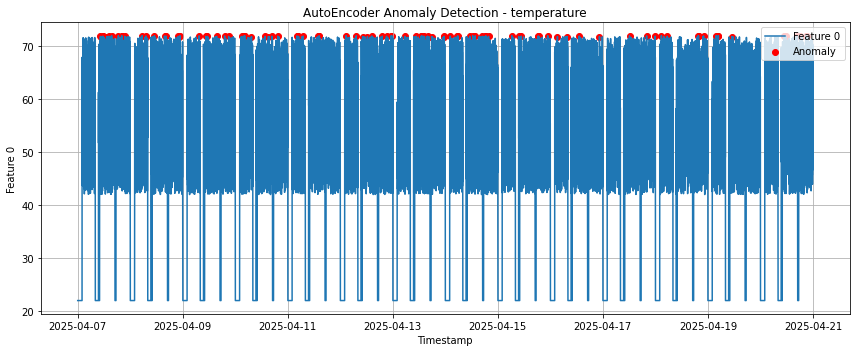

c:\Users\Thomas\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔍 Sensor: vibration
Confusion Matrix:
[[20045   101]
 [    0     0]]

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00     20146
        True       0.00      0.00      0.00         0

    accuracy                           0.99     20146
   macro avg       0.50      0.50      0.50     20146
weighted avg       1.00      0.99      1.00     20146



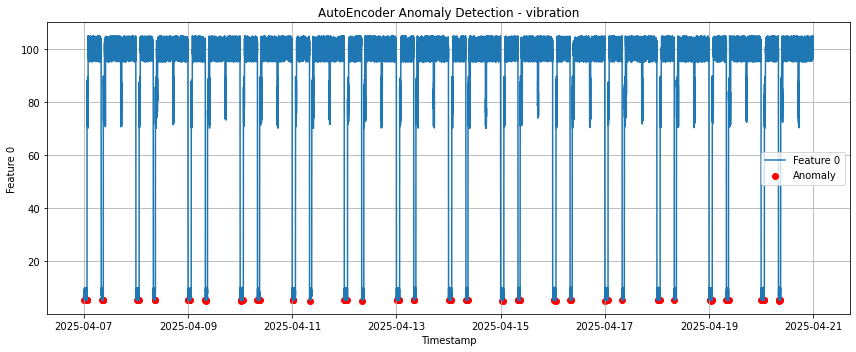

c:\Users\Thomas\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔍 Sensor: rpm
Confusion Matrix:
[[20045   101]
 [    0     0]]

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00     20146
        True       0.00      0.00      0.00         0

    accuracy                           0.99     20146
   macro avg       0.50      0.50      0.50     20146
weighted avg       1.00      0.99      1.00     20146



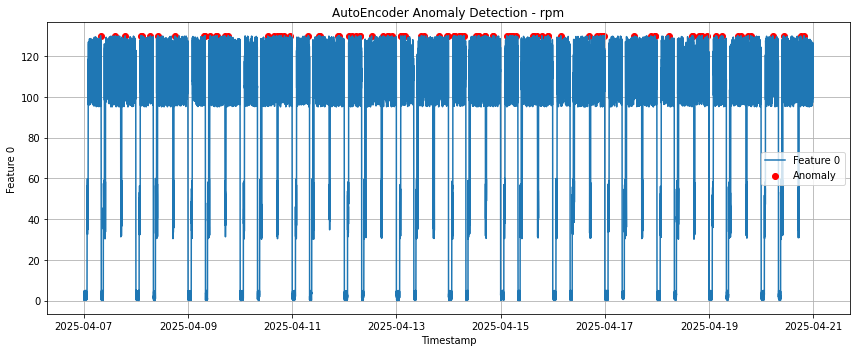

c:\Users\Thomas\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔍 Sensor: power
Confusion Matrix:
[[20045    86]
 [    0    15]]

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     20131
        True       0.15      1.00      0.26        15

    accuracy                           1.00     20146
   macro avg       0.57      1.00      0.63     20146
weighted avg       1.00      1.00      1.00     20146



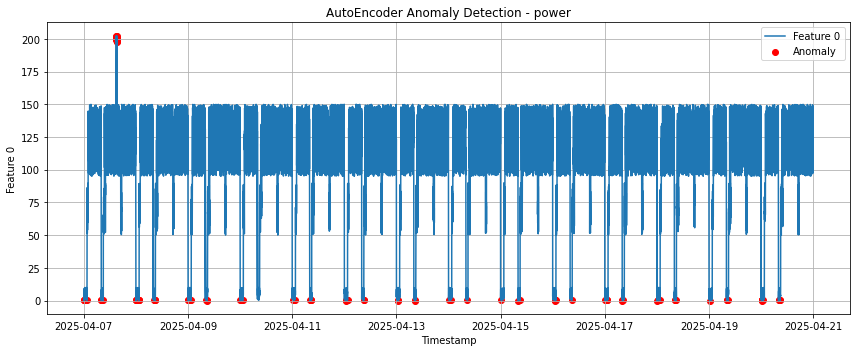

In [8]:
# Load CSV file
file_name = "../test_csv/motor_power_high.csv"
df = pd.read_csv(file_name, parse_dates=["timestamp"])
tags = df["sensor"].unique()

for tag in tags:
    tag_df = df[df["sensor"] == tag].copy()

    # Scale the feature
    scaler = MinMaxScaler()
    tag_df["scaled"] = scaler.fit_transform(tag_df[["feature_0"]])

    # Only train on normal data
    X_train = tag_df[tag_df["is_anomaly"] == False][["scaled"]]

    # AutoEncoder model
    model = Sequential([
        Dense(8, activation="relu", input_shape=(1,)),
        Dense(4, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="mse")

    # Train the model
    model.fit(X_train, X_train, epochs=50, batch_size=64, validation_split=0.1,
              callbacks=[EarlyStopping(patience=5)], verbose=0)

    # Predict and compute reconstruction error
    tag_df["recon"] = model.predict(tag_df[["scaled"]], verbose=0)
    tag_df["recon_error"] = np.abs(tag_df["scaled"] - tag_df["recon"])

    # Threshold based on training error
    threshold = tag_df["recon_error"].quantile(0.995)
    tag_df["anomaly_label"] = tag_df["recon_error"] > threshold

    # Confusion Matrix & Classification Report
    y_true = tag_df["is_anomaly"]
    y_pred = tag_df["anomaly_label"]

    print(f"\n🔍 Sensor: {tag}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    # Plot results
    plt.figure(figsize=(12, 5))
    plt.plot(tag_df["timestamp"], tag_df["feature_0"], label="Feature 0")
    plt.scatter(tag_df[tag_df["anomaly_label"]]["timestamp"],
                tag_df[tag_df["anomaly_label"]]["feature_0"],
                color="red", label="Anomaly")
    plt.title(f"AutoEncoder Anomaly Detection - {tag}")
    plt.xlabel("Timestamp")
    plt.ylabel("Feature 0")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()